## 创建环境

In [3]:
import pandas as pd
from coptpy import *

# Create COPT environment
env = Envr()

# === Create COPT model ===
model = env.createModel("m")

Cardinal Optimizer v7.2.4. Build date Dec  6 2024
Copyright Cardinal Operations 2024. All Rights Reserved



## 描述问题
### 定义变量

In [4]:
T, N, K, M, L, J = 30, 64, 2, 1000, 1200, 10000
W = [0, 3, 2]  # 资源的单位重量
P = [0, 5, 10]  # 资源的单位价格

comsumption = [{}, {"晴朗": 5, "高温": 8, "沙暴": 10}, {"晴朗": 7, "高温": 6, "沙暴": 10}]

# 说明：为了更贴合数学形式，把下标为0的元素设为空，从下标1开始放置数据，

### 定义下标集合
为了方便批量添加变量和约束，定义如下几个下标的集合

In [5]:
# t -- 天数, i -- 区域, k -- 资源
t_i = [(t, i) for t in range(1, T + 1) for i in range(1, N + 1)]  # 1 ~ T, 1 ~ N
t_k = [(t, k) for t in range(1, T + 1) for k in range(1, K + 1)]  # 1 ~ T, 1 ~ K
i_k = [(i, k) for i in range(1, N + 1) for k in range(1, K + 1)]  # 1 ~ N, 1 ~ K
t_0_i = [(t, i) for t in range(0, T + 1) for i in range(1, N + 1)]  # 0 ~ T, 1 ~ N
t_0_k = [(t, k) for t in range(0, T + 1) for k in range(1, K + 1)]  # 0 ~ T, 1 ~ K
t_i_k = [(t, i, k) for t in range(1, T + 1) for i in range(1, N + 1) for k in range(1, K + 1)]  # 1 ~ T, 1 ~ N, 1 ~ K

### 读取数据，设置参数
读取天气和地图的数据，设置所需的参数

**在读取数据之前，同学们可以思考一下，如何将地图转换成可计算数据？**

In [6]:
import numpy as np

# !!!此处的和N，与解题程序中的变量命名有重叠；需要注意程序运行顺序
small_N = 8
N = small_N*small_N
pos = [ [0 for j in range(N)]for i in range(N)]

for index in range(N):
    row = index // small_N
    col = index % small_N
    # print(index)
    if col == small_N-1: # 最后一列特殊处理
        if row != small_N-1:
            pos[index][index+small_N] = 1; pos[index+small_N][index] = 1
        continue
    if row % 2 == 0:
        if row == 0: # 第一行
            pos[index][index+1] = 1; pos[index+1][index] = 1
            pos[index][index+small_N] = 1; pos[index+small_N][index] = 1
            continue
        else:
            pos[index][index+1] = 1; pos[index+1][index] = 1
            pos[index-small_N][index] = 1; pos[index-small_N][index] = 1
            pos[index][index+small_N] = 1; pos[index+small_N][index] = 1
    else:
        if row == small_N-1: # 最后一行
            pos[index][index+1] = 1; pos[index+1][index] = 1
            pos[index-small_N][index] = 1; pos[index-small_N][index] = 1
            pos[index-(small_N-1)][index] = 1; pos[index-(small_N-1)][index] = 1
            continue
        else:
            pos[index][index+1] = 1; pos[index+1][index] = 1
            pos[index-small_N][index] = 1; pos[index-small_N][index] = 1
            pos[index][index+small_N] = 1; pos[index+small_N][index] = 1
            pos[index-(small_N-1)][index] = 1; pos[index-(small_N-1)][index] = 1
            pos[index][index+(small_N+1)] = 1; pos[index+(small_N+1)][index] = 1
            
# print(pos) 

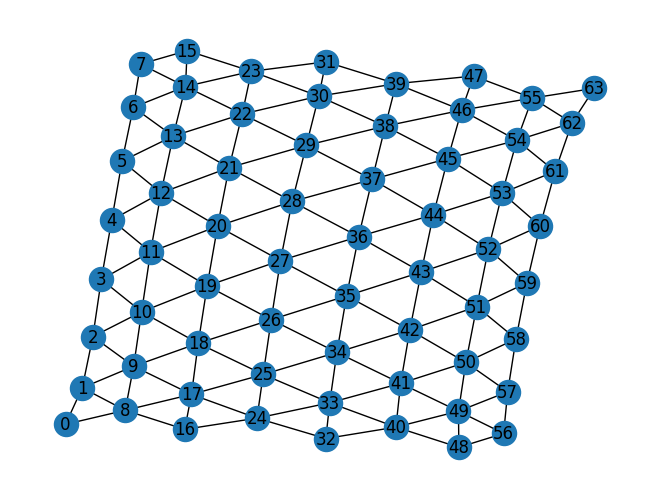

In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# 创建一个邻接矩阵
adj_matrix = np.asarray(pos)
 
# 从邻接矩阵创建图
G = nx.Graph(adj_matrix)
 
# 查看图的结构和邻接列表
# print("Nodes:", G.nodes())
# print("Edges:", G.edges())
 
# 可视化图
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

In [37]:
# 读取地图和天气数据
weather_data = pd.read_csv('weather.csv', encoding='gbk')
print(weather_data)
pos_data = pd.read_csv('pos.csv', encoding='gbk')
print(pos_data)

# 特殊位置
village = {39: [1, 2], 62: [1, 2]}
mine_pos = {30: 1000, 55: 1000}
end_pos = [64]

    1   2   3   4   5   6   7   8   9  10  ... Unnamed: 30 Unnamed: 31  \
0  高温  高温  晴朗  沙暴  晴朗  高温  沙暴  晴朗  高温  高温  ...         NaN         NaN   

  Unnamed: 32 Unnamed: 33 Unnamed: 34 Unnamed: 35 Unnamed: 36 Unnamed: 37  \
0         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 38 Unnamed: 39  
0         NaN         NaN  

[1 rows x 40 columns]
    1  2  3  4  5  6  7  8  9  10  ...  55  56  57  58  59  60  61  62  63  64
0   0  1  0  0  0  0  0  0  1   0  ...   0   0   0   0   0   0   0   0   0   0
1   1  0  1  0  0  0  0  0  1   1  ...   0   0   0   0   0   0   0   0   0   0
2   0  1  0  1  0  0  0  0  0   1  ...   0   0   0   0   0   0   0   0   0   0
3   0  0  1  0  1  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
4   0  0  0  1  0  1  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
.. .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
59  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   1   0  

In [38]:
A = {(t, k): comsumption[k][weather_data.loc[0, str(t)]] for t, k in t_k}  # 第t天第k种资源的基础消耗量
B = {t: weather_data.loc[0, str(t)] == "沙暴" for t in range(1, T + 1)}  # 沙暴天气集合
D = {(i, k): int(i in village.keys() and k in village[i]) for i, k in i_k}  # 是否可以在区域i购买资源k
E = {i: int(i in mine_pos) for i in range(1, N + 1)}  # 区域i是否为矿山
F = {i: int(i in end_pos) for i in range(1, N + 1)}  # 区域i是否为终点
G = {i: mine_pos[i] if i in mine_pos else 0 for i in range(1, N + 1)}  # 在区域i挖矿的收益；区域i不是矿山则收益为0
H = {(i, j): pos_data.loc[i - 1, str(j)] if i != j else 1 for i in range(1, N + 1) for j in range(1, N + 1)}  # 区域i和j是否相邻

**让我们来深入了解一下A-H，这些变量的具体意义**

In [39]:
print(A)
print(B)
print(D)
print(E)
print(F)
print(G)
print(H)

{(1, 1): 8, (1, 2): 6, (2, 1): 8, (2, 2): 6, (3, 1): 5, (3, 2): 7, (4, 1): 10, (4, 2): 10, (5, 1): 5, (5, 2): 7, (6, 1): 8, (6, 2): 6, (7, 1): 10, (7, 2): 10, (8, 1): 5, (8, 2): 7, (9, 1): 8, (9, 2): 6, (10, 1): 8, (10, 2): 6, (11, 1): 10, (11, 2): 10, (12, 1): 8, (12, 2): 6, (13, 1): 5, (13, 2): 7, (14, 1): 8, (14, 2): 6, (15, 1): 8, (15, 2): 6, (16, 1): 8, (16, 2): 6, (17, 1): 10, (17, 2): 10, (18, 1): 10, (18, 2): 10, (19, 1): 8, (19, 2): 6, (20, 1): 8, (20, 2): 6, (21, 1): 5, (21, 2): 7, (22, 1): 5, (22, 2): 7, (23, 1): 8, (23, 2): 6, (24, 1): 5, (24, 2): 7, (25, 1): 10, (25, 2): 10, (26, 1): 8, (26, 2): 6, (27, 1): 5, (27, 2): 7, (28, 1): 5, (28, 2): 7, (29, 1): 8, (29, 2): 6, (30, 1): 8, (30, 2): 6}
{1: False, 2: False, 3: False, 4: True, 5: False, 6: False, 7: True, 8: False, 9: False, 10: False, 11: True, 12: False, 13: False, 14: False, 15: False, 16: False, 17: True, 18: True, 19: False, 20: False, 21: False, 22: False, 23: False, 24: False, 25: True, 26: False, 27: False, 28

### 添加决策变量

In [40]:
# 第t天是否到达第i个区域，包含第0天
x = model.addVars(t_0_i, vtype=COPT.BINARY, nameprefix='x')

# y为过程量，表达第t天是否在区域i停留, t从1开始
y = model.addVars(t_i, vtype=COPT.BINARY, nameprefix='y')

# 第t天购买第k种资源的数量; 第0天的购买量为起始购买量
z = model.addVars(t_0_k, vtype=COPT.INTEGER, nameprefix='z', lb=0)

# 第t天是否挖矿
w = model.addVars([i for i in range(1, T + 1)], vtype=COPT.BINARY, nameprefix='w')

### 定义中间变量和相应约束关系

In [41]:
# 第t天是否到达第k个资源点
a = model.addVars(t_0_k, vtype=COPT.BINARY, nameprefix='a')
model.addConstrs((a[(t, k)] == quicksum(x[(t, i)] * D[(i, k)] for i in range(1, N + 1)) for t, k in t_0_k),
                 r"a_{t,k}=\sum_{i=1}^{N}D_{i,k}")

b = model.addVars([i for i in range(1, T + 1)], vtype=COPT.BINARY, nameprefix='b')
model.addConstrs((b[t] == quicksum(y[(t, i)] * E[i] for i in range(1, N + 1)) for t in range(1, T + 1)),
                 r"b_t = \sum_{i=1}^{N}y_{t,i}E_i")

d = model.addVars([i for i in range(0, T + 1)], vtype=COPT.BINARY, nameprefix='d')
model.addConstrs((d[t] == quicksum(x[(t, i)] * F[i] for i in range(1, N + 1)) for t in range(0, T + 1)),
                 r"b_t = \sum_{i=1}^{N}x_{t,i}F_i")

u = model.addVars(t_0_k, vtype=COPT.INTEGER, nameprefix='u', lb=0)

v = model.addVars(t_0_k, vtype=COPT.INTEGER, nameprefix='v', lb=0)

s = model.addVars([i for i in range(0, T + 1)], vtype=COPT.INTEGER, nameprefix='s')

### 添加约束条件

In [42]:
# (1) 第0天在第1个区域
model.addConstr((x[(0, 1)] == 1), "（1）x_{0,1} = 1")

# (2) 最后一天必须到达终点
model.addConstr((x[(T, N)] == 1), "（2）x_{T,N} = 1")

# (3) 每天只能在其中一个区域
model.addConstrs((x.sum(t, "*") == 1 for t in range(0, T + 1)), nameprefix=r"3 \sum_{i=1}^Nx_{t,i} = 1")
# x size = [(t, i) for t in range(0, T + 1) for i in range(1, N + 1)]
# for t in range(0, T + 1):
#     model.addConstr(x.sum(t, "*") == 1)

# (4) 相邻两天区域必须相邻
model.addConstrs(((x[(t, i)] + x[(t - 1, j)] <= H[(i, j)] + 1) for t, i in t_i for j in range(1, N + 1)),
                 nameprefix="4 x_{t,i} + x_{t-1,i} <= H_{i,j} + 1")

# (5).购买前资源剩余量必须大于等于0，见变量u的下界

# (6).购买后资源满足负重约束
model.addConstrs((quicksum(v[(t, k)] * W[k] for k in range(1, K + 1)) <= L for t in range(0, T + 1)),
                 nameprefix=r"6 \sum_{k=1}^{K}v_{t,k}*W_k <= L")

# (7). 沙暴天气必须停留
model.addConstrs((y.sum(t, "*") == 1 for t in range(1, T + 1) if B[t]), nameprefix="7 stop")

# (8). 满足挖矿条件才可以挖矿
model.addConstrs((w[t] <= b[t] for t in range(1, T + 1)), nameprefix="8 w_t <= b_t")

# (9). 只有在资源点才可以购买资源
model.addConstrs((z[(t, k)] <= a[(t, k)] * M for t in range(1, T + 1) for k in range(1, K + 1)),
                 nameprefix="9 z_{t,k} <= a_{t,k}*M")

# (10). 到达终点不能返回
model.addConstrs((d[t] <= d[t + 1] for t in range(0, T)), nameprefix="10 d[t]<=d[t+1]")

# (11). y与x的关系约束
model.addConstrs((y[(t, i)] <= x[(t, i)] for t, i in t_i), nameprefix="11.1 y_{t,i} <= x_{t,i}")
model.addConstrs((y[(t, i)] <= x[(t - 1, i)] for t, i in t_i), nameprefix="11.2 y_{t,i} <= x_{t-1,i}")
model.addConstrs((x[(t - 1, i)] + x[(t, i)] <= y[(t, i)] + 1 for t, i in t_i),
                 nameprefix="11.3 x_{t-1,i} + x_{t,i} <= y_{t,i} + 1")

In [43]:
# 状态转移方程
# (1) 剩余资源状态转移
model.addConstrs((u[(t, k)] == v[(t - 1, k)] - \
                  (2 * w[t] - y.sum(t, "*") + 2 - d[t - 1]) * A[(t, k)] \
                  for t in range(1, T + 1) for k in range(1, K + 1)),
                 nameprefix=r"u_{t,k} = v_{t-1,k} - (2*w_t-\sum_{i=1}^Ny_{t,i} + 2 -  d_{t-1}) "
                            r"* \sum_{i=1}^{N}A_{t,i,k}*x_{t-1,i}")
model.addConstrs((v[(t, k)] == u[(t, k)] + z[(t, k)] for t, k in t_0_k), nameprefix='v_{t,k} = u_{t,k} + z_{t,k}')

# (2) 初始资源为0
model.addConstrs((u[(0, k)] == 0 for k in range(1, K + 1)), nameprefix="u_{0,k}=0")

# (3) 初始资金购买资源
model.addConstr((s[0] == J - quicksum(z[(0, k)] * P[k] for k in range(1, K + 1))),
                r"s_{0}=J-\sum_{k=1}^{K}z_{0,k}*P_k")

# (4) 资金转移方程
model.addConstrs((s[t] == s[t - 1] + 1000 * w[t] - 2 * quicksum(z[(t, k)] * P[k] for k in range(1, K + 1))
                  for t in range(1, T + 1)), nameprefix=r"s_{t} = s_{t-1} + G*w_t - 2*\sum_{k=1}^{K}z_{t,k}*P_{k}")

### 设置目标函数，求解模型

In [44]:
model.setObjective(s[T] + 0.5 * quicksum(v[(T, k)] * P[k] for k in range(1, K + 1)), COPT.MAXIMIZE)

In [45]:
# 求解
model.solve()

Model fingerprint: 582275d8

Using Cardinal Optimizer v7.2.4 on Windows
Hardware has 14 cores and 20 threads. Using instruction set X86_AVX2 (10)
Maximizing a MIP problem

The original problem has:
    129108 rows, 4274 columns and 266631 non-zero elements
    4057 binaries and 217 integers

Starting the MIP solver with 20 threads and 64 tasks

Presolving the problem

The presolved problem has:
    3385 rows, 1759 columns and 47884 non-zero elements
    1651 binaries and 108 integers


     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution     Gap   Time
         0         1      --       0  3.284000e+04            --     Inf  1.97s
         0         1      --     313  1.698137e+04            --     Inf  2.60s
         0         1      --     325  1.681339e+04            --     Inf  2.87s
         0         1      --     430  1.662340e+04            --     Inf  3.04s
         0         1      --     435  1.657689e+04            --     Inf  3.21s
         0         1      -- 

H        0         1      --     793  1.522404e+04  8.135000e+03  46.56% 18.32s
         0         1      --     745  1.522240e+04  8.135000e+03  46.56% 18.55s
H        0         1      --     745  1.522240e+04  8.145000e+03  46.49% 18.56s
         0         1      --     785  1.522040e+04  8.145000e+03  46.49% 18.82s
         0         1      --     784  1.522040e+04  8.145000e+03  46.49% 18.82s
         0         1      --     779  1.522008e+04  8.145000e+03  46.49% 19.04s
         0         1      --     777  1.521971e+04  8.145000e+03  46.48% 19.24s
         0         1      --     296  1.521893e+04  8.145000e+03  46.48% 19.50s
         0         1      --     294  1.521893e+04  8.145000e+03  46.48% 19.56s
         0         1      --     294  1.521893e+04  8.145000e+03  46.48% 19.61s
         0         1      --     750  1.521883e+04  8.145000e+03  46.48% 19.73s
         0         1      --     713  1.521831e+04  8.145000e+03  46.48% 19.96s
         0         1      --     750  1.

       180        10   505.6     194  1.413171e+04  1.273000e+04  9.919% 42.05s
       190        21   483.3     138  1.413171e+04  1.273000e+04  9.919% 42.05s
       200        29   466.5     121  1.413171e+04  1.273000e+04  9.919% 42.05s
       300         5   358.7     177  1.384630e+04  1.273000e+04  8.062% 45.53s
       400        58   287.8     231  1.382658e+04  1.273000e+04  7.931% 46.74s
       500        33   244.4     133  1.371530e+04  1.273000e+04  7.184% 49.38s
       600        21   224.4     152  1.369471e+04  1.273000e+04  7.044% 51.99s
       700        14   199.8     131  1.359752e+04  1.273000e+04  6.380% 53.91s
       800        10   184.3      82  1.325840e+04  1.273000e+04  3.985% 58.28s

     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution     Gap   Time
       862         0   175.9     287  1.273000e+04  1.273000e+04  0.000% 62.80s

Best solution   : 12730.000000000
Best bound      : 12730.000000000
Best gap        : 0.0000%
Solve time      : 62.81


## 查看最优解和最优值

In [ ]:
if model.status == COPT.OPTIMAL:
    print(f'Objective value: {model.objval}')
    print(f'Solving Time: {model.SolvingTime} seconds')
     # 获取 x（每天所在的区域）
        
    x_sol = {key: x[key].x for key in t_0_i if x[key].x > 0.5}
    print("\n每天所在的区域:")
    for key, value in sorted(x_sol.items()):
        print(f"Day {key[0]} -> Location {key[1]}")

    # 获取 y（是否停留）
    y_sol = {key: y[key].x for key in t_i if y[key].x > 0.5}
    print("\n每天停留的区域:")
    for key, value in sorted(y_sol.items()):
        print(f"Day {key[0]} -> Stayed at Location {key[1]}")

    # 获取 z（每天购买的资源）
    z_sol = {key: z[key].x for key in t_0_k if z[key].x > 0}
    print("\n每天购买的资源:")
    for key, value in sorted(z_sol.items()):
        print(f"Day {key[0]} -> Resource {key[1]}: {value}")

    # 获取 w（是否挖矿）
    w_sol = {key: w[key].x for key in range(1, T + 1) if w[key].x > 0.5}
    print("\n挖矿记录:")
    for key, value in sorted(w_sol.items()):
        print(f"Day {key} -> Mined")

    # 获取 s（资金变化）
    s_sol = {key: s[key].x for key in range(0, T + 1)}
    print("\n每天资金:")
    for key, value in sorted(s_sol.items()):
        print(f"Day {key} -> Money: {value}")

    # 获取 v（剩余资源）
    v_sol = {key: v[key].x for key in t_0_k if v[key].x > 0}
    print("\n每天剩余资源:")
    for key, value in sorted(v_sol.items()):
        print(f"Day {key[0]} -> Resource {key[1]}: {value}")